# Data Exploration

Hi. This notebook serves as a summary of my data exploration journey. The purpose of this notebook is to give readers an understanding of the dataset characteristic and appreciate the analytical steps, necessary in any Deep Learning (DL) project. The outcome of this analysis will impact the performance of the DL project and is the most time consuming. The project can be broken down into the following sections:

-  Analyze the Dataset:
   -  Evaluate Dataset Contents and Characteristics
   -  Exploit Data Leak Information
-  Peek into the Dataset (Training + Test)
   -  Visualizing the Complexity of the Ship Dection Problem   
   -  Dealing with Class Imbalance Problem   
-  Identify and Export test Parameters for use by Deep Learning Algorithm

# 1.   Analyze the Dataset

## Load the necessary supporting and custom libraries into workspace

In [24]:
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util import montage2d as montage
import preprocess_lib_clean as prelib  # Load Custom Library
from skimage.morphology import label
from torch.utils import data as utils_data
import torchvision.transforms as transforms
import os.path as osp
import glob
import random
from PIL import Image

# For Training
import torchvision
import torch.nn as nn
from models import *


# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

## 1.2   Some debug flags

In [2]:
double_check = 1
data_generation = 0

## 1.3   Locate the Datasets (Training + Test) and Labels

In [3]:
# Common path variables
train_path = '../train/'
test_path = '../test/'
train_label_path = '../input/train_ship_segmentations.csv'
test_label_path = '../input/test_ship_segmentations.csv'

# 2. Exploiting Data Leak information

Upon loading of the labels, you will immediately notice it contains 2 columns of data - ImageID and EncodedPixels.

In [63]:
masks_data = prelib.LoadMyData(train_label_path, pandas=True)
print('Total Number of images found --> ' + str(masks_data['ImageId'].value_counts().shape[0]))
masks_data.head(5)

Total Number of images found --> 104070


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


Fortunately, there are existing functions to decode RLE and we are able to transform the encoded information to derive the contents of each ImageID to infom us if a ship is present in the picture. If a ship is present,then provide the count.

In [5]:
trainlabel_load_ship = prelib.load_file("train")
testlabel_load_ship = prelib.load_file("test")
trainlabel_load_ship.head(5)

,HasShip,TotalShips
ImageId,,
00003e153.jpg,False,0.0
000155de5.jpg,True,1.0
00021ddc3.jpg,True,9.0
0002756f7.jpg,True,2.0
0002d0f32.jpg,False,0.0


 In addition, NULL values are observed and it serves to inform that no ship is detected in the image. The next step will be to better understand the number and distribution of the Ships per picture, within our dataset.

# 3. Peek into the Dataset (Training + Test)

## Training Dataset Information


------------------------------------ 
----- Training Set Data ------------ 
------------------------------------ 
-- Overview of TotalShips Column --- 
count    104070.000000
mean          0.538388
std           1.337660
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: TotalShips, dtype: float64

------------------------------------ 
 ------ Additional Info ------
Images Found: 104070
Images with ships:    0.28 (29070)
Images with no ships: 0.72 (75000)
Total Number of Ships Present:  56030
Mean number of Ships per image with Ship: 1.9274165806673547
Standard Deviation on Ships per image with Ship: 1.9309598753704391


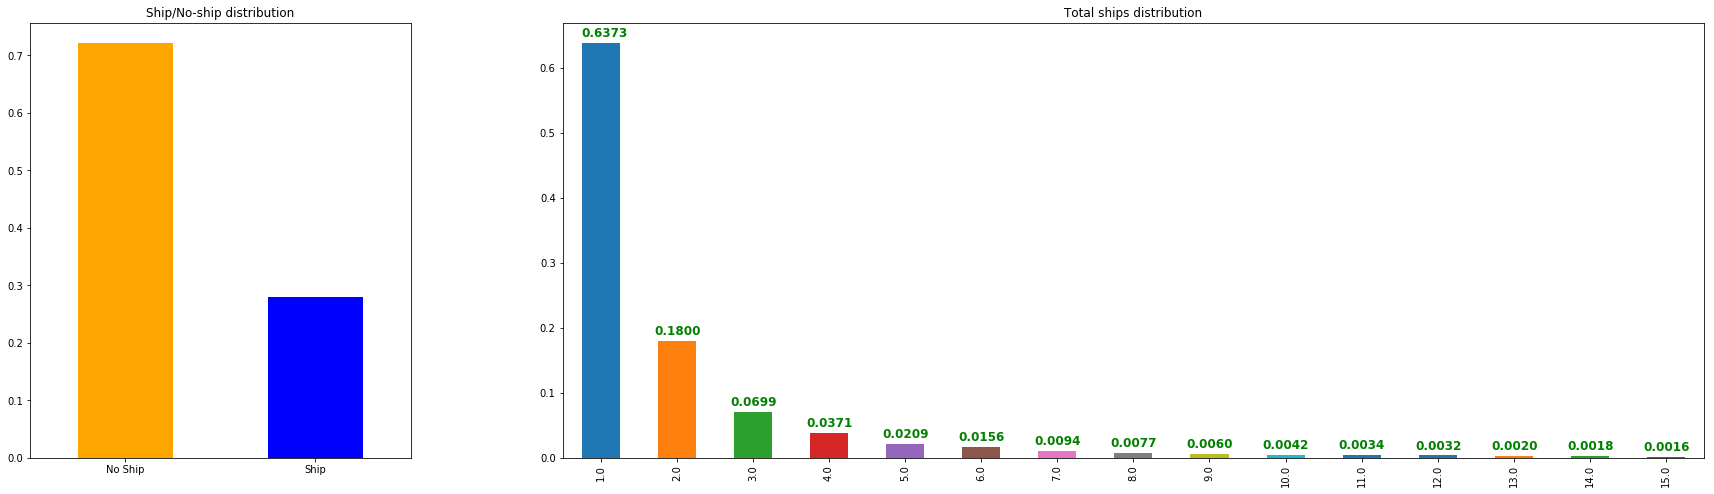

In [6]:
# Input: Training label dataset
print('------------------------------------ ')
print('----- Training Set Data ------------ ')
print('------------------------------------ ')
print('-- Overview of TotalShips Column --- ')
print(trainlabel_load_ship['TotalShips'].describe())
print('')
print('------------------------------------ ')
prelib.show_data_distrib(trainlabel_load_ship)  # Training Data

## Test Dataset Information

-------------------------------- 
-------- Test Set Data --------- 
-------------------------------- 
count    88486.000000
mean         0.290362
std          0.995581
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: TotalShips, dtype: float64

-------------------------------- 
 ------ Additional Info ------
Images Found: 88486
Images with ships:    0.15 (13486)
Images with no ships: 0.85 (75000)
Total Number of Ships Present:  25693
Mean number of Ships per image with Ship: 1.9051609076078897
Standard Deviation on Ships per image with Ship: 1.851268007877711


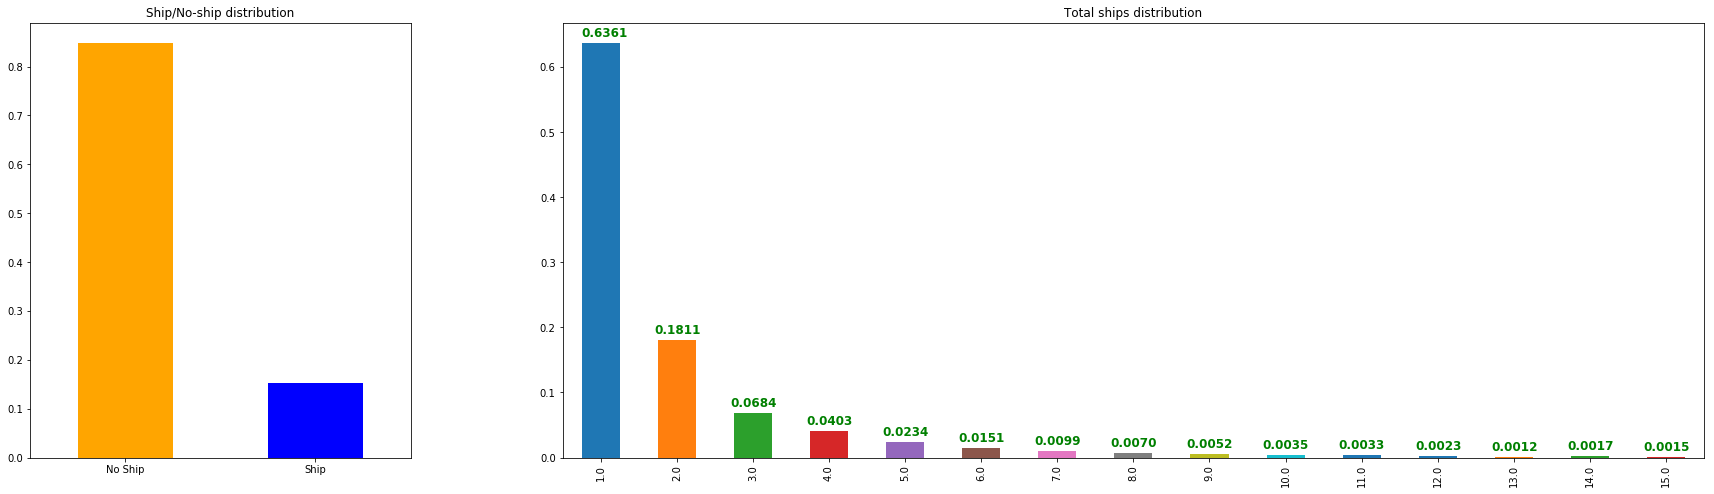

In [7]:
print('-------------------------------- ')
print('-------- Test Set Data --------- ')
print('-------------------------------- ')
print(testlabel_load_ship['TotalShips'].describe())
print('')
print('-------------------------------- ')
prelib.show_data_distrib(testlabel_load_ship)  # Test Data

## Quick Analysis of Results

From the provided graphs, the data imbalance is obvious - 70% of the pictures do not have ships. One of the serious implication is that the inferred DL model end up being very good at detecting pictures with NO ship. Even in pictures with ships present, most of the pictures (~64%) contains an image with 1 ship. To deal with the imbalance problem, the data generation method is  proposed. It should also be noted that each imageIDs may appear multiple times as it is used to indicate the ship's picture coordinates

### Determine Number of Valid Images with mask

In [37]:
images_with_ship = masks_data.ImageId[masks_data.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values) 
print('Image files with masks: ' +str(len(images_with_ship)) )

Image files with masks: 29070


### Image Generation by RandomRotation

c53929aed.jpg


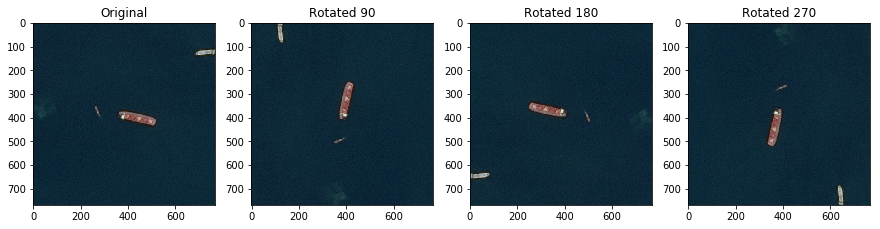

In [61]:
# Load File parameters
# filext = '.jpg'
# testfilename = '6bb3e7515'
# testfile_rotation = train_path + testfilename + filext
rand_image = images_with_ship[random.randint(1, len(images_with_ship))]
testfile_rotation = train_path + rand_image
print(rand_image)

# Load the test file into memory and perform image manipulation
img = Image.open(testfile_rotation)
img_1 = np.array(img)
img_2 = np.array(img.rotate(90))
img_3 = np.array(img.rotate(180))
img_4 = np.array(img.rotate(270))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 10))
ax1.set_title('Original')
ax2.set_title('Rotated 90')
ax3.set_title('Rotated 180')
ax4.set_title('Rotated 270')
ax1.imshow(img_1)
ax2.imshow(img_2)
ax3.imshow(img_3)
ax4.imshow(img_4)

plt.show()

# Visualize Images with Ships present and Mask Information

So what exactly is a mask? 
A Mask refers to the action of taking a copy of the original image, setting some of the image pixel intesity values to a zero or "background" value. As the pixel intesity value is mostly zero in the mask image, then the pixel intensity of the resulting image, can be clearly seen. In our case, we used the EncodedPixel information to visually outline the detected ship, within the masked image. The code segment below will perform just that for 5 images and a side-by-side comparison will be used to illustrate the concept of a mask and how it can be extended to creating a bounding box.

Image 002fdcf51.jpg


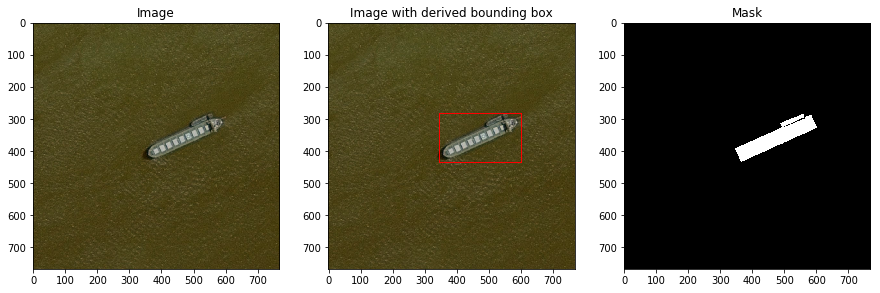

Image 00319c32d.jpg


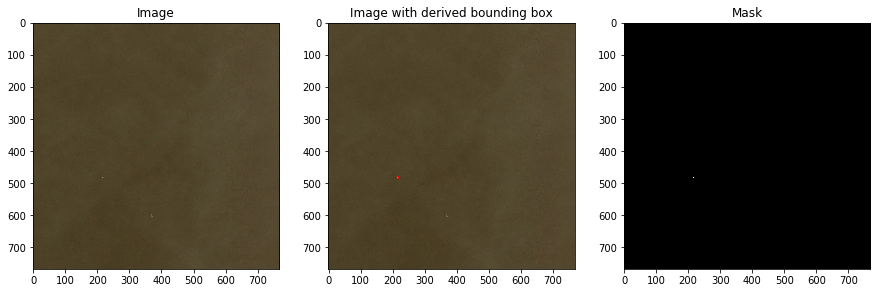

Image 003d43308.jpg


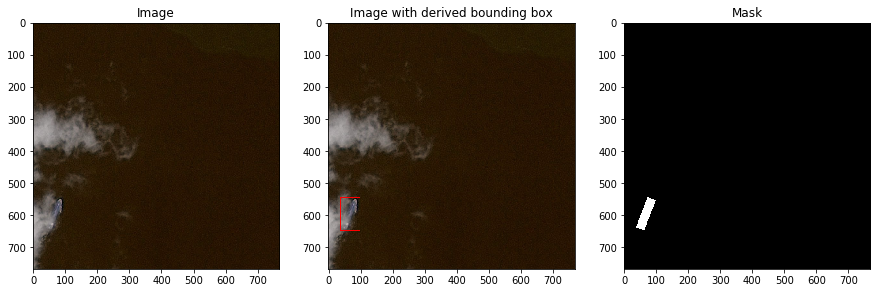

Image 003e2c95d.jpg


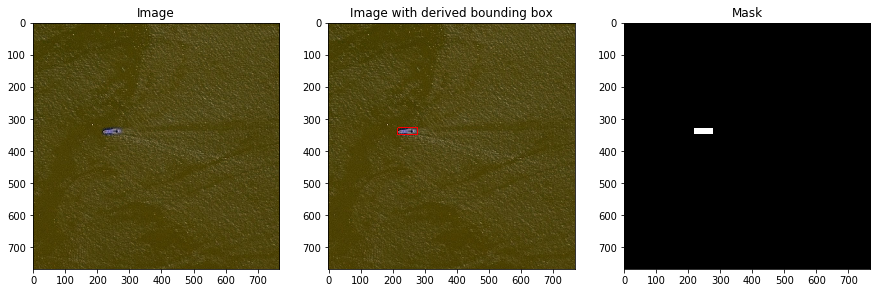

Image 0040cf4e9.jpg


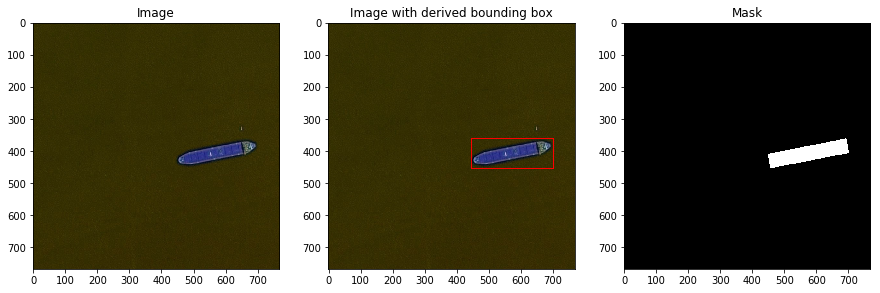

In [47]:
for i in range(5):
    image = images_with_ship[23+i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 15))
    img_0 = cv2.imread(train_path + image)
    rle_0 = masks_data.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = prelib.masks_as_image(rle_0)

    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)  # Print the ImageID
    for prop in props:
#         print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax3.set_title('Mask')
    ax2.set_title('Image with derived bounding box')
    ax3.imshow(mask_0[...,0], cmap='gray')
    ax2.imshow(img_1)
    plt.show()

In [ ]:
# Identify and Export test Parameters for use by Deep Learning Algorithm

## Create Dictionary of Bounding Boxes w.r.t. Images - for DL algorithm use

As part of the data preparation process, a dictionary of values (eg. imageID and Bounding Box coordinates) is required to feed and teach the Deep Learning Models during the training phase. In this project, the information will be fed to a VGG16 model followed by Faster-RCNN model for image segmentation purposes. For informational purposes, we have included a progress bar and utilized python's garbage collector to minimize memory hogging. 

*Note: Task Duration is affected by the amount of data, to be processed, and the computing platform that this code is performed on. For example, this task was performed on a 6-core CPU computing platform and required ~13mins*

In [17]:
if data_generation == True:
    import gc 
    bboxes_dict = {}
    i = 0
    count_ships = 0
    for image in tqdm(images_with_ship):
        img_0 = cv2.imread(train_path + image)
        rle_0 = masks_data.query('ImageId=="'+image+'"')['EncodedPixels']
        mask_0 = prelib.masks_as_image(rle_0)

        lbl_0 = label(mask_0) 
        props = regionprops(lbl_0)
        bboxes = []
        count_ships = count_ships + len(props)
        for prop in props:
            bboxes.append(prop.bbox)


        i = i + 1
        if i % 400 == 0:
            gc.collect()    

        bboxes_dict[image] = bboxes.copy()

100%|████████████████████████████████████████████████████████████████████████████| 29070/29070 [12:38<00:00, 38.57it/s]


# Export the information

In [19]:
if data_generation == True:
    bboxes_df = pd.DataFrame([bboxes_dict])
    bboxes_df = bboxes_df.transpose()
    bboxes_df.columns = ['bbox_list']
    bboxes_df.head()
    
    # Save to csv
    bboxes_df.to_csv('bbox_dictionary.csv')

# View of Information exported

In [23]:
if data_generation == True:
    read_data = prelib.LoadMyData('bbox_dictionary.csv', pandas=True)
read_data.head()
# print(read_data)

,Unnamed: 0,bbox_list
0,000155de5.jpg,"[(465, 344, 501, 448)]"
1,00021ddc3.jpg,"[(705, 96, 720, 121), (732, 123, 768, 178), (6..."
2,0002756f7.jpg,"[(36, 324, 67, 351)]"
3,00031f145.jpg,"[(124, 443, 153, 472)]"
4,00053c6ba.jpg,"[(124, 736, 139, 752)]"
